In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading Data Sets

In [27]:
df_train = pd.read_csv("datasets/train.csv")
df_val = pd.read_csv("datasets/val.csv")
df_test = pd.read_csv("datasets/test.csv")

How Many Rows and Features in Our Data Sets

In [28]:
df_train.shape

(1000000, 10)

In [29]:
df_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB


We Have 7 numerical columns and we will add another one later and 3 object columns we will drop 1 of them (id)

Let's Check Is If The range Of :
1. Longitude [-90 , 90]
2. Latitude [-180, 180]
3. Passenger Numbers must be >= 0

In [31]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1000000.0,1.534793,0.498788,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1000000.0,1.665353,1.315723,0.000000,1.000000,1.000000,2.000000,7.000000e+00
pickup_longitude,1000000.0,-73.973475,0.065404,-121.933342,-73.991852,-73.981728,-73.967346,-6.133553e+01
pickup_latitude,1000000.0,40.750947,0.033745,34.359695,40.737372,40.754131,40.768379,5.188108e+01
dropoff_longitude,1000000.0,-73.973421,0.065432,-121.933304,-73.991341,-73.979767,-73.963036,-6.133553e+01
dropoff_latitude,1000000.0,40.751829,0.035782,34.359695,40.735928,40.754551,40.769833,4.392103e+01
trip_duration,1000000.0,954.884971,3882.070116,1.000000,397.000000,662.000000,1074.000000,2.227612e+06


The Columns' -We Have Mentioned- values Range is Natural

There Is Outlier or missleading rows in our(trip_duration) column, the third quartile is **1074 Sec** and the max is **2.2 * 10^6 sec** About 25 Day 
This is Incridble for a nyc taxi trip, we Need To Filter this Outliers, We Can Filter The Trips Exceedes One Day

In [32]:
df_train = df_train[(df_train['trip_duration'] > 60) & (df_train['trip_duration'] < 86400)]  

We Will Extract a new Feature From These Features -> **Great Circle Distance**

In [33]:
longitude_a = df_train['pickup_longitude'].to_numpy()
latitude_a = df_train['pickup_latitude'].to_numpy()
longitude_b = df_train['dropoff_longitude'].to_numpy()
latitude_b = df_train['dropoff_latitude'].to_numpy()

This is The Formula We Used To Generate The Great Circle Distance called **Haversine** Between Two Points If You Have 
Thier logitude and latitude

In [34]:
def haversine(lat1: np.ndarray, lon1: np.ndarray, lat2: np.ndarray, lon2: np.ndarray) -> np.ndarray:
    R = 6371.0  # Radius of Earth in kilometers

    # Convert degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Differences between coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    
    # Fix precision errors: ensure a is within [0, 1]
    a = np.clip(a, 0, 1)

    # Central angle
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance


In [35]:
df_train.insert(loc=len(df_train.columns) -1, column='Distance', value=pd.DataFrame(haversine(latitude_a, longitude_a, latitude_b, longitude_b)))

Let's See The New Column Statistics

In [36]:
df_train['Distance'].describe().T

count    988147.000000
mean          3.458832
std           4.430494
min           0.000000
25%           1.244912
50%           2.104644
75%           3.889889
max        1240.908677
Name: Distance, dtype: float64

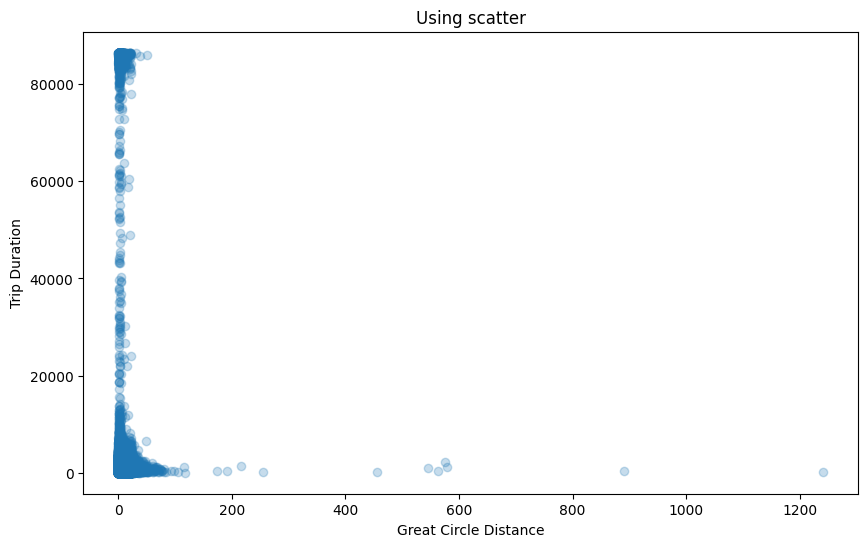

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train['Distance'], df_train['trip_duration'], alpha=0.25)
plt.title("Using scatter")
plt.xlabel("Great Circle Distance")
plt.ylabel("Trip Duration")
plt.show()

We See The RealationShip **Is not Linear** because there a lot of Factors Affecting The Trip Duration
Ex: 
- The Distance Might Be Low But The road may have high traffic in this trip

Let's check how many null-values in the train, val and test set

In [38]:
df_train.isna().sum()

id                       0
vendor_id                0
pickup_datetime          0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
store_and_fwd_flag       0
Distance              5909
trip_duration            0
dtype: int64

**There isn't any null-values in the Data**
Let's Explore Is there **Invalid Data** in the origianl data set

In [39]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,994056.0,1.535525,0.498737,1.000000,1.000000,2.000000,2.000000,2.000000
passenger_count,994056.0,1.666779,1.316856,0.000000,1.000000,1.000000,2.000000,6.000000
pickup_longitude,994056.0,-73.973591,0.065013,-121.933342,-73.991859,-73.981750,-73.967445,-61.335529
pickup_latitude,994056.0,40.750999,0.033417,34.359695,40.737423,40.754158,40.768387,51.881084
dropoff_longitude,994056.0,-73.973536,0.065040,-121.933304,-73.991341,-73.979782,-73.963120,-61.335529
dropoff_latitude,994056.0,40.751886,0.035482,34.359695,40.735981,40.754581,40.769844,43.921028
Distance,988147.0,3.458832,4.430494,0.000000,1.244912,2.104644,3.889889,1240.908677
trip_duration,994056.0,958.184723,3188.696197,61.000000,401.000000,665.000000,1078.000000,86392.000000


For Now We Will Drop The NUll values in Distance, until we Make The BaseLine Model 

In [40]:
df_train = df_train[df_train['Distance'].notnull()]
df_train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
Distance              0
trip_duration         0
dtype: int64

In [41]:
df_train['store_and_fwd_flag']

0         N
1         N
2         N
3         N
4         N
         ..
994051    N
994052    N
994053    N
994054    N
994055    N
Name: store_and_fwd_flag, Length: 988147, dtype: object

This flag indicates whether the trip record was held in vehicle memory before
sending to the vendor, aka “store and forward,” because the vehicle did not
have a connection to the server.
Y = store and forward trip
N = not a store and forward trip

Let's Viualize How Many Store and Forward Trips 

In [42]:
df_train['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    982715
Y      5432
Name: count, dtype: int64

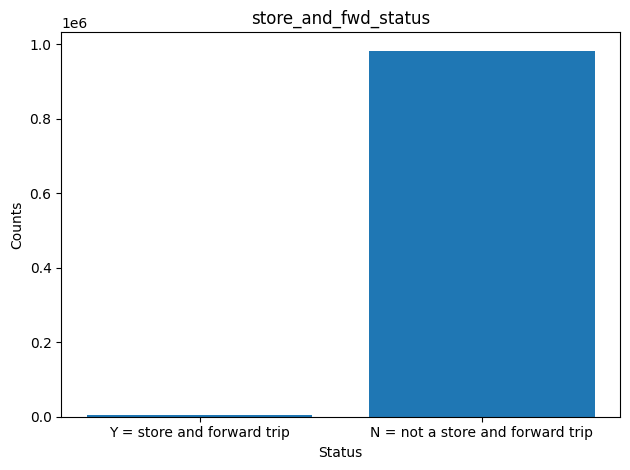

In [43]:
status = ['Y = store and forward trip', 'N = not a store and forward trip']
counts = [(df_train['store_and_fwd_flag'] == 'Y').sum(), (df_train['store_and_fwd_flag'] == 'N').sum()]
plt.bar(status, counts)
plt.title('store_and_fwd_status')
plt.xlabel('Status')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

Observation:
- Y is not zero but it is very small if we compare it with N

I Noticed The Time Of The Trip Maybe Affecting The Trip Duration, Imagin You Drive Your Car About 3 or 5 am
There is a big Chance To Reach Your Distnation Faster Than if You Drive Your Car in The Crowded Steets About 12 to 2 pm
,so We Can Categorize The Time Zones Into about 3 or 4 categoreis 
- 12 am to 4 am
- 5 am to 11 am
- 12 pm to 4 pm
- 5 pm to 11 pm

Let's Binning the Time Data

In [44]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])

df_train.insert(loc=len(df_train.columns) - 1, column='hour', value=df_train['pickup_datetime'].dt.hour)

bins = [0, 4, 11, 16, 23]

labels = ["12 am to 4 am", "5 am to 11 am", "12 pm to 4 pm", "5 pm to 11 pm"]

df_train.insert(loc=len(df_train.columns) - 1, column='time_category', value=pd.cut(df_train['hour'], bins=bins, labels=labels, include_lowest=True))


In [45]:
mapping = {
    "12 am to 4 am": 1,
    "5 am to 11 am": 2,
    "12 pm to 4 pm": 4,
    "5 pm to 11 pm": 3
}

df_train['time_category'] = df_train['time_category'].map(mapping)


In [46]:
df_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,Distance,hour,time_category,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,2.763050,7,2,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,1.959178,12,4,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,1.404772,2,1,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,1.978660,17,3,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,20.837745,17,3,4967


In [47]:
df_train.drop(columns=[ 'id', 'pickup_datetime', 'store_and_fwd_flag' ,'hour'], inplace=True)

Now We Can Drop Id Column, However we shouldn't dropping the vendor id column because different vendors may providing 
different cars which mabye vendor 1 cars is faster than vendor 2 cars

Now After Dropping Unimportant Columns And Replace Some Of Them by New Columns Like Time Category

The Ascending Order Have Meaning The number 4 Means mostly crowded time Afficing the Time Duration

and 1 is the minmum Crowdness in Roads from my common sense

store_and_fwd_flag, i think this column doesn't have impact on the trip duration so i dropped it 

we Have replaced the pickup datetime

In [48]:
df_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,time_category,trip_duration
0,2,1,-73.985611,40.735943,-73.980331,40.760468,2.763050,2,1040
1,2,1,-73.978394,40.764351,-73.991623,40.749859,1.959178,4,827
2,2,5,-73.989059,40.744389,-73.973381,40.748692,1.404772,1,614
3,2,2,-73.990326,40.731136,-73.991264,40.748917,1.978660,3,867
4,1,4,-73.789497,40.646675,-73.987137,40.759232,20.837745,3,4967
